In [1]:
# All the Import Statements
# File to setup the image data to fine-tune the 
from collections import defaultdict
import os
import re
import cv2
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerImageProcessor
import json
from huggingface_hub import hf_hub_download
from PIL import Image
from torch import nn
from sklearn.metrics import accuracy_score
import evaluate
metric = evaluate.load("mean_iou")
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

print('hi')

hi


In [2]:
# setup labels
# customizable id's
road_labels = {
  "0": "not_road",
  "1": "road",
}
road_label2id = {v: k for k, v in road_labels.items()}


# load id2label mapping from a JSON on the hub
# think we might need to adjust the num_labels and the id2label situation to fit out specific case
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

print('hi2')

hi2


In [3]:
# setup the model
# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=road_labels,
                                                         label2id=road_label2id,
)

print('hi3')

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hi3


In [4]:
# do a test forward pass
# define the image processor
image_processor = SegformerImageProcessor(do_reduce_labels=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# just kinda testing this out and figuring out if it works
image = Image.open("/Users/rorybeals/Downloads/Road Identification Data/test/206_sat.jpg")
png_image = Image.open("/Users/rorybeals/Downloads/Road Identification Data/train/562_mask.png")
model.to(device)
pixel_vals = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_vals.shape)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_vals)

torch.Size([1, 3, 512, 512])


(1024, 1024)


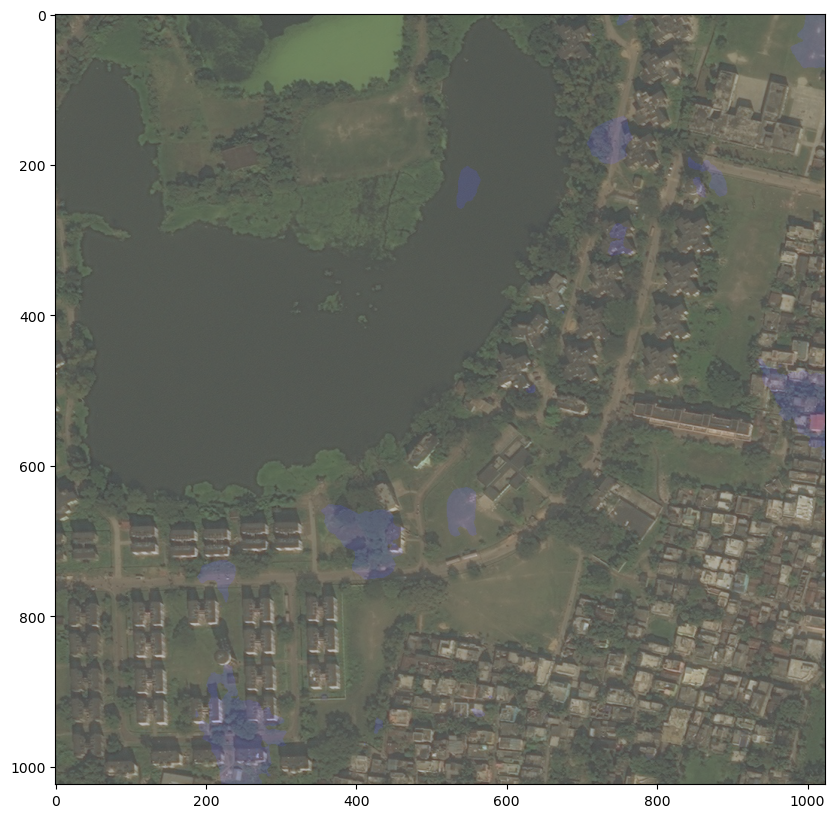

ahhhhh


In [5]:
# visualize the prediction
# took this from online to help with visualizing the segmentation
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]
     
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map.shape)

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]
# cv2.imwrite("image_out.jpg", color_seg)

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

print('ahhhhh')

In [13]:
# setup all the lists of the images
# this function is supposed to process the png files and encode them with proper values that we can use to retrain the model a bit
def process_png(filename):
    image = Image.open(filename)
    binary_mask = np.array(image.convert("L"))
    binary_mask = np.where(binary_mask > 0, 1, 0)
    # encoded_mask = np.zeros_like(binary_mask, dtype=np.int64)
    # for label, class_name in road_labels.items():
    #     encoded_mask[binary_mask == label] = label
    return torch.tensor(binary_mask)

# gonna see if we can train this thangggg
# get all of the filenames separated
path = '/Users/rorybeals/Downloads/Road Identification Data/train/'
jpg_files = []
png_files = []
for file in os.listdir(path):
    if file.endswith('.jpg'):
        jpg_files.append(file)
    else: png_files.append(file)

# define our training data and labels
training_images = []
training_labels = []

data_dict = defaultdict(dict)
for file in os.listdir(path):
    num, type_ = file.split('_')
    data_dict[num][type_] = file

# set up the training_images and training_labels lists of filenames
for file in jpg_files:
    file_num = file.split('_')[0]
    filename = path + '/' + file
    training_images.append(filename)
    png_image = data_dict[file_num]['mask.png']
    png_filename = path + '/'+  png_image
    training_labels.append(png_filename)
    if (len(training_images) == 30):
        break

processed_images = []
processed_labels = []

for image_filename, label_filename in zip(training_images, training_labels):
    sat_image = Image.open(image_filename)
    pixel_vals = image_processor(sat_image, return_tensors="pt").pixel_values.to(device)
    processed_images.append(pixel_vals)
    labels = process_png(label_filename)
    processed_labels.append(labels)

print('hi4')

hi4


In [14]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path)
        self.ann_dir = os.path.join(self.root_dir, sub_path)

        # read images
        # image_file_names = []
        # for files in jpg_files:
        #   image_file_names.extend(files)
        # print(len(image_file_names))
        self.images = sorted(jpg_files)

        # read annotations
        # annotation_file_names = []
        # for files in png_files:
        #   annotation_file_names.extend(files)
        # print(len(annotation_file_names))
        self.annotations = sorted(png_files)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")
        print(encoded_inputs.shape)

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [15]:
# setup the batches and the optimizers and stuff
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir='/Users/rorybeals/Downloads/Road Identification Data/', image_processor=image_processor)

/Users/rorybeals/miniconda3/envs/artificial/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [16]:
# setup the batches and the optimizers and stuff
# Convert lists of tensors to PyTorch tensors
processed_images_tensor = torch.stack(processed_images)
processed_labels_tensor = torch.stack(processed_labels)

dataset = TensorDataset(processed_images_tensor, processed_labels_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# set up some batches
training_images_tensor = tf.convert_to_tensor(training_images)
training_labels_tensor = tf.convert_to_tensor(training_labels)

print('hi5')

#adjust the loss function

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight)

    def forward(self, inputs, targets):
        return self.loss(inputs, targets)

# Assuming class 1 (road) is more important than class 0 (not road)
weights = torch.tensor([1.0, 3.0])  # More weight for class 1

criterion = WeightedCrossEntropyLoss(weight=weights)


# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
image_processor = SegformerImageProcessor(do_reduce_labels=True)
model.to(device)

hi5


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [18]:
from tqdm.notebook import tqdm

# train the model
model.train()
for epoch in range(5):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for batch in dataloader:
        # get the inputs;
        # pixel_values = batch["pixel_values"].to(device)
        # labels = batch["labels"].to(device)
         # get the inputs;
        pixel_values, labels = batch
        pixel_values = pixel_values[:, 0, :, :, :]
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits
        logits_resized = torch.nn.functional.interpolate(logits, size=(1024, 1024), mode='bilinear', align_corners=False)
        loss = criterion(logits_resized, labels)

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if True == True:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )
    print("Loss:", loss.item())
    print("Mean_iou:", metrics["mean_iou"])
    print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


/Users/rorybeals/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/rorybeals/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 0.5589772462844849
Mean_iou: 0.46700382232666016
Mean accuracy: 0.5
Epoch: 1
Loss: 0.3988704979419708
Mean_iou: 0.47501254081726074
Mean accuracy: 0.5
Epoch: 2
Loss: 0.1910763382911682
Mean_iou: 0.494840145111084
Mean accuracy: 0.5
Epoch: 3
Loss: 0.3443201184272766
Mean_iou: 0.48163676261901855
Mean accuracy: 0.5
Epoch: 4
Loss: 0.45387208461761475
Mean_iou: 0.4691195487976074
Mean accuracy: 0.5


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


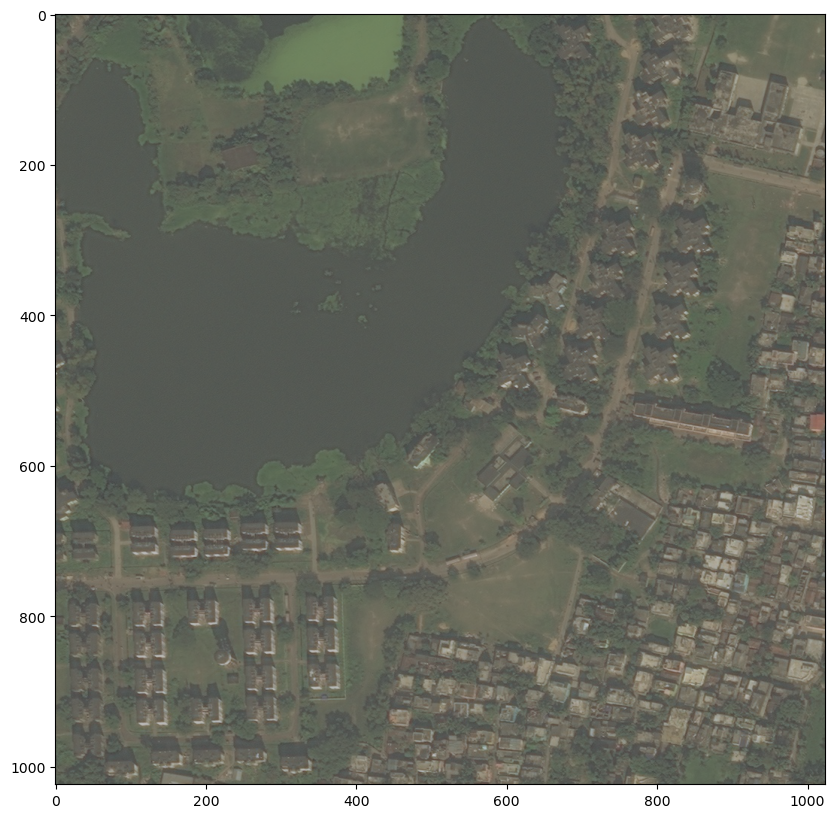

In [19]:
# classify the image again
# just kinda testing this out and figuring out if it works
image = Image.open("/Users/rorybeals/Downloads/Road Identification Data/test/206_sat.jpg")
png_image = Image.open("/Users/rorybeals/Downloads/Road Identification Data/train/562_mask.png")
pixel_vals = image_processor(image, return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_vals)

     
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()